In [1]:
%load_ext watermark

In [2]:
%watermark -d -a 'Sebastian Raschka' -v -p scikit-learn,numpy,pandas

Sebastian Raschka 24/02/2015 

CPython 3.4.2
IPython 2.3.1

scikit-learn 0.15.2
numpy 1.9.1
pandas 0.15.2


# Implementing a Weighted Majority Rule Ensemble Classifier in scikit-learn

<br>
<br>

Here, I want to present a simple and conservative approach of implementing a weighted majority rule ensemble classifier in [scikit-learn](http://scikit-learn.org/stable/) that yielded remarkably good results when I tried it in a [kaggle](http://www.kaggle.com) competition. For me personally, kaggle competitions are just a nice way to try out and compare different approaches and ideas -- basically an opportunity to learn in a controlled environment with nice datasets.  

Of course, there are other implementations of more sophisticated [ensemble methods](http://scikit-learn.org/stable/modules/ensemble.html) in scikit-learn, such as [bagging classifiers](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html), [random forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), or the famous [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) algorithm. However, as far as I am concerned, they all require the usage of a common "base classifier."

In contrast, my motivation for the following approach was to combine conceptually different machine learning classifiers and use a majority vote rule. The reason for this was that I had trained a set of equally well performing models, and I wanted to balance out their individual weaknesses.

<br>
<br>

### Sections

- [Classifying Iris Flowers Using Different Classification Models](#Classifying-Iris-Flowers-Using-Different-Classification-Models)
- [Implementing the Majority Voting Rule Ensemble Classifier](#Implementing-the-Majority-Voting-Rule-Ensemble-Classifier)
- [Additional Note About the EnsembleClassifier Implementation: Class Labels vs. Probabilities](#Additional-Note-About-the-EnsembleClassifier-Implementation:-Class-Labels-vs.-Probabilities)
- [EnsembleClassifier - Tuning Weights](#EnsembleClassifier---Tuning-Weights)
- [EnsembleClassifier - Pipelines](#EnsembleClassifier---Pipelines)
- [Some Final Words](#Some-Final-Words)
- [Appendix I - Plotting-Averaged-Probabilities](#Appendix-I---Plotting-Averaged-Probabilities)
- [Appendix II - Plotting Decision Boundaries](#Appendix-II---Plotting-Decision-Boundaries)
- [Appendix III - GridSearch Support](#Appendix-III---GridSearch-Support)

<br>
<br>

# Classifying Iris Flowers Using Different Classification Models

[[back to top](#Sections)]

For a simple example, let us use three different classification models to classify the samples in the [Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set): Logistic regression, a naive Bayes classifier with a Gaussian kernel, and a random forest classifier -- an ensemble method itself. At this point, let's not worry about preprocessing the data and training and test sets. Also, we will only use 2 feature columns (sepal width and petal height) to make the classification problem harder. 

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

In [3]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
import numpy as np

np.random.seed(123)

clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = GaussianNB()

print('5-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3], ['Logistic Regression', 'Random Forest', 'naive Bayes']):

    scores = cross_validation.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


5-fold cross validation:

Accuracy: 0.90 (+/- 0.05) [Logistic Regression]
Accuracy: 0.92 (+/- 0.05) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [naive Bayes]


As we can see from the cross-validation results above, the performance of the three models is almost equal.

<br>
<br>

# Implementing the Majority Voting Rule Ensemble Classifier

[[back to top](#Sections)]

### Hard Voting

Now, we will implement a simple `EnsembleClassifier` class that allows us to combine the three different classifiers. We define a `predict` method that let's us simply take the majority rule of the predictions by the classifiers.
E.g., if the prediction for a sample is

- classifier 1 -> class 1
- classifier 2 -> class 1
- classifier 3 -> class 2

we would classify the sample as "class 1." 

If weights are provided, the classifier multiplies the occurence of a class by this weight. 

For example, given the weights [$w_1$, $w_2$, $w_3$] = [3, 1, 1]

- classifier 1 -> class 1 * $w_1$ -> 1, 1, 1
- classifier 2 -> class 2 * $w_2$ -> 2
- classifier 3 -> class 2 * $w_3$ -> 2

we would classify the sample as "class 1, " which can also be illustrated by the following code snippet:

In [3]:
import numpy as np
np.argmax(np.bincount([1, 2, 2], weights=[3, 1, 1]))

1

### Soft Voting

Furthermore, we add a `weights` parameter, which let's us assign a specific weight to each classifier. In order to work with the weights, we collect the predicted class probabilities for each classifier, multiply it by the classifier weight, and take the average. Based on these weighted average probabilties, we can then assign the class label.

To illustrate this with a simple example, let's assume we have 3 classifiers and a 3-class classification problems where we assign equal weights to all classifiers (the default): w1=1, w2=1, w3=1.

The weighted average probabilities for a sample would then be calculated as follows:

| classifier      | class 1  | class 2  | class 3  |
|-----------------|----------|----------|----------|
| classifier 1    | w1 * 0.2 | w1 * 0.5 | w1 * 0.3 |
| classifier 2    | w2 * 0.6 | w2 * 0.3 | w2 * 0.1 |
| classifier 3    | w3 * 0.3 | w3 * 0.4 | w3 * 0.3 |
| weighted average| 0.37     | 0.4      | 0.3      |

We can see in the table above that class 2 has the highest weighted average probability, thus we classify the sample as class 2.

Now, let's put it into code and apply it to our Iris classification.

In [72]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class EnsembleClassifier(BaseEstimator, ClassifierMixin, TransformerMixin):
    """ Soft Voting/Majority Rule classifier for unfitted clfs.

    Parameters
    ----------
    clfs : array-like, shape = [n_classifiers]
      A list of classifiers.
      Invoking the `fit` method on the `VotingClassifier` will fit clones
      of those original classifiers that will be stored in the class attribute
      `self.clfs_`.

    voting : str, {'hard', 'soft'} (default='hard')
      If 'hard', uses predicted class labels for majority rule voting.
      Else if 'soft', predicts the class label based on the argmax of
      the sums of the predicted probalities, which is recommended for
      an ensemble of well-calibrated classifiers.

    weights : array-like, shape = [n_classifiers], optional (default=`None`)
      Sequence of weights (`float` or `int`) to weight the occurances of
      predicted class labels (`hard` voting) or class probabilities
      before averaging (`soft` voting). Uses uniform weights if `None`.

    Attributes
    ----------
    classes_ : array-like, shape = [n_predictions]

    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.linear_model import LogisticRegression
    >>> from sklearn.naive_bayes import GaussianNB
    >>> from sklearn.ensemble import RandomForestClassifier
    >>> clf1 = LogisticRegression(random_state=1)
    >>> clf2 = RandomForestClassifier(random_state=1)
    >>> clf3 = GaussianNB()
    >>> X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
    >>> y = np.array([1, 1, 1, 2, 2, 2])
    >>> eclf1 = VotingClassifier(clfs=[clf1, clf2, clf3], voting='hard')
    >>> eclf1 = eclf1.fit(X, y)
    >>> print(eclf1.predict(X))
    [1 1 1 2 2 2]
    >>> eclf2 = VotingClassifier(clfs=[clf1, clf2, clf3], voting='soft')
    >>> eclf2 = eclf2.fit(X, y)
    >>> print(eclf2.predict(X))
    [1 1 1 2 2 2]
    >>> eclf3 = VotingClassifier(clfs=[clf1, clf2, clf3],
    ...                          voting='soft', weights=[2,1,1])
    >>> eclf3 = eclf3.fit(X, y)
    >>> print(eclf3.predict(X))
    [1 1 1 2 2 2]
    >>>
    """
    def __init__(self, clfs, voting='hard', weights=None):
        
        self.clfs = clfs
        self.named_clfs = {key:value for key,value in _name_estimators(clfs)}
        self.voting = voting
        self.weights = weights
        

    def fit(self, X, y):
        """ Fit the clfs.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object
        """
        if isinstance(y, np.ndarray) and len(y.shape) > 1 and y.shape[1] > 1:
            raise NotImplementedError('Multilabel and multi-output'\
                                      ' classification is not supported.')

        if self.voting not in ('soft', 'hard'):
            raise ValueError("Voting must be 'soft' or 'hard'; got (voting=%r)"
                             % voting)

        if self.weights and len(self.weights) != len(self.clfs):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d clfs'
                             % (len(self.weights), len(self.clfs)))

        self.le_ = LabelEncoder()
        self.le_.fit(y)
        self.classes_ = self.le_.classes_
        self.clfs_ = []
        for clf in self.clfs:
            fitted_clf = clone(clf).fit(X, self.le_.transform(y))
            self.clfs_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        maj : array-like, shape = [n_samples]
            Predicted class labels.
        """
        if self.voting == 'soft':

            maj = np.argmax(self.predict_proba(X), axis=1)

        else:  # 'hard' voting
            predictions = self._predict(X)

            maj = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)

        maj = self.le_.inverse_transform(maj)
        return maj

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.
        """
        avg = np.average(self._predict_probas(X), axis=0, weights=self.weights)
        return avg

    def transform(self, X):
        """ Return class labels or probabilities for X for each estimator.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        -------
        If `voting='soft'`:
          array-like = [n_classifiers, n_samples, n_classes]
            Class probabilties calculated by each classifier.
        If `voting='hard'`:
          array-like = [n_classifiers, n_samples]
            Class labels predicted by each classifier.
        """
        if self.voting == 'soft':
            return self._predict_probas(X)
        else:
            return self._predict(X)

    def get_params(self, deep=True):
        """ Return estimator parameter names for GridSearch support"""
        if not deep:
            return super(EnsembleClassifier, self).get_params(deep=False)
        else:
            out = self.named_clfs.copy()
            for name, step in six.iteritems(self.named_clfs):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

    def _predict(self, X):
        """ Collect results from clf.predict calls. """
        return np.asarray([clf.predict(X) for clf in self.clfs_]).T

    def _predict_probas(self, X):
        """ Collect results from clf.predict calls. """
        return np.asarray([clf.predict_proba(X) for clf in self.clfs_])

In [33]:
# Majority Rule (hard) Voting


np.random.seed(123)
eclf = EnsembleClassifier(clfs=[clf1, clf2, clf3], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):

    scores = cross_validation.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.90 (+/- 0.05) [Logistic Regression]
Accuracy: 0.92 (+/- 0.05) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [naive Bayes]
Accuracy: 0.95 (+/- 0.05) [Ensemble]


In [7]:
# Average Probabilities (soft) Voting

np.random.seed(123)
eclf = EnsembleClassifier(clfs=[clf1, clf2, clf3], voting='soft', weights=[2,1,5])

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):

    scores = cross_validation.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))



Accuracy: 0.90 (+/- 0.05) [Logistic Regression]
Accuracy: 0.92 (+/- 0.05) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [naive Bayes]
Accuracy: 0.94 (+/- 0.04) [Ensemble]


<br>
<br>

# EnsembleClassifier - Tuning Weights

[[back to top](#Sections)]

Let's get back to our `weights` parameter. Here, we will use a naive brute-force approach to find the optimal weights for each classifier to increase the prediction accuracy.

In [8]:
import pandas as pd

np.random.seed(123)

df = pd.DataFrame(columns=('w1', 'w2', 'w3', 'mean', 'std'))

i = 0
for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range(1,4):
            
            if len(set((w1,w2,w3))) == 1: # skip if all weights are equal
                continue
            
            eclf = EnsembleClassifier(clfs=[clf1, clf2, clf3], voting='soft', weights=[w1,w2,w3])
            scores = cross_validation.cross_val_score(
                                            estimator=eclf,
                                            X=X, 
                                            y=y, 
                                            cv=5, 
                                            scoring='accuracy',
                                            n_jobs=1)
            
            df.loc[i] = [w1, w2, w3, scores.mean(), scores.std()]
            i += 1
            
df.sort(columns=['mean', 'std'], ascending=False)

,w1,w2,w3,mean,std
2,1,2,1,0.953333,0.033993
17,3,1,2,0.953333,0.033993
16,3,1,1,0.946667,0.045216
20,3,2,2,0.946667,0.045216
1,1,1,3,0.946667,0.040000
6,1,3,2,0.946667,0.033993
7,1,3,3,0.946667,0.033993
11,2,2,1,0.946667,0.033993
13,2,3,1,0.946667,0.033993
14,2,3,2,0.946667,0.033993


<br>
<br>

# EnsembleClassifier - Pipelines

[[back to top](#Sections)]

Of course, we can also use the `EnsembleClassifier` in `Pipelines`. This is especially useful if a certain classifier does a pretty good job on a certain feature subset or requires different `preprocessing` steps. For demonstration purposes, let us implement a simple `ColumnSelector` class.

In [9]:
class ColumnSelector(object):
    """ 
    A feature selector for scikit-learn's Pipeline class that returns
    specified columns from a numpy array.
    
    """
    
    def __init__(self, cols):
        self.cols = cols
        
    def transform(self, X, y=None):
        return X[:, self.cols]

    def fit(self, X, y=None):
        return self

In [10]:
from sklearn.pipeline import Pipeline 
from sklearn.lda import LDA

pipe1 = Pipeline([
               ('sel', ColumnSelector([1])),    # use only the 1st feature
               ('clf', GaussianNB())])

pipe2 = Pipeline([
               ('sel', ColumnSelector([0, 1])), # use the 1st and 2nd feature
               ('dim', LDA(n_components=1)),    # Dimensionality reduction via LDA
               ('clf', LogisticRegression())])

eclf = EnsembleClassifier([pipe1, pipe2])
scores = cross_validation.cross_val_score(eclf, X, y, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.95 (+/- 0.03) [Ensemble]


<br>
<br>

# Ensemble EnsembleClassifier

[[back to top](#Sections)]

If one `EnsembleClassifier` is not yet enough, we can also build an ensemble classifier of ensemble classifiers. Just like the other examples above, the following code is just meant to be a technical demonstration:

In [11]:
eclf1 = EnsembleClassifier(clfs=[clf1, clf2, clf3], voting='soft', weights=[5,2,1])
eclf2 = EnsembleClassifier(clfs=[clf1, clf2, clf3], voting='soft', weights=[4,2,1])
eclf3 = EnsembleClassifier(clfs=[clf1, clf2, clf3], voting='soft', weights=[1,2,4])

eclf = EnsembleClassifier(clfs=[eclf1, eclf2, eclf3], voting='soft', weights=[2,1,1])

scores = cross_validation.cross_val_score(eclf, X, y, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.95 (+/- 0.03) [Ensemble]


<br>
<br>

# Some Final Words

[[back to top](#Sections)]

When we applied the `EnsembleClassifier` to the iris example above, the results surely looked nice. But we have to keep in mind that this is just a toy example. The majority rule voting approach might not always work so well in practice, especially if the ensemble consists of more "weak" than "strong" classification models. Also, although we used a cross-validation approach to overcome the overfitting challenge, please always keep a spare validation dataset to evaluate the results.

Anyway, if you are interested in those approaches, I added them to my [`mlxtend`](https://github.com/rasbt/mlxtend) Python module; in `mlxtend` (short for "machine learning library extensions"), I collect certain things that I personally find useful but are not available in other packages yet.

You can install `mlxtend` via

    pip install mlxtend

and then load the `ColumnSelector` or `EnsembleClassifier` via

    from mlxtend.sklearn import ColumnSelector
    from mlxtend.sklearn import EnsembleClassifier

# <br> <br>

## Appendix I - Plotting Averaged Probabilities

[[back to top](#Sections)]

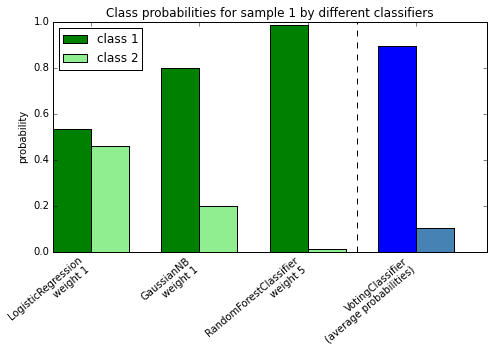

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

clf1 = LogisticRegression(random_state=123)
clf2 = RandomForestClassifier(random_state=123)
clf3 = GaussianNB()
X = np.array([[-1.0, -1.0], [-1.2, -1.4], [-3.4, -2.2], [1.1, 1.2]])
y = np.array([1, 1, 2, 2])

eclf = EnsembleClassifier(clfs=[clf1, clf2, clf3], 
                        voting='soft', 
                        weights=[1, 1, 5])

# predict class probabilities for all classifiers
probas = [c.fit(X, y).predict_proba(X) for c in (clf1, clf2, clf3, eclf)]

# get class probabilities for the first sample in the dataset
class1_1 = [pr[0,0] for pr in probas]
class2_1 = [pr[0,1] for pr in probas]

#####################
# plotting 

N = 4  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(7,5))

# bars for classifier 1-3
p1 = ax.bar(ind, np.hstack(([class1_1[:-1],[0]])), width, color='green')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1],[0]])), width, color='lightgreen')

# bars for VotingClassifier
p3 = ax.bar(ind, [0, 0, 0, class1_1[-1]], width, color='blue')
p4 = ax.bar(ind + width, [0, 0, 0, class2_1[-1]], width, color='steelblue')

# plot annotations
plt.axvline(2.8, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
ax.set_xticklabels(['LogisticRegression\nweight 1', 
                    'GaussianNB\nweight 1', 
                    'RandomForestClassifier\nweight 5', 
                    'VotingClassifier\n(average probabilities)'],
                   rotation=40,
                   ha='right')
plt.ylim([0,1])
plt.ylabel('probability')
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'] , loc='upper left')
plt.tight_layout()
#plt.savefig('../../images/sklean_ensemble_probas.png')
plt.show()

<br>
<br>

## Appendix II - Plotting Decision Boundaries

[[back to top](#Sections)]

In [13]:
from mlxtend.matplotlib import plot_decision_regions
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from mlxtend.sklearn import EnsembleClassifier

%matplotlib inline

In [31]:

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0,2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = EnsembleClassifier(clfs=[clf1, clf2, clf3], voting='soft', weights=[2,1,2])

clf1.fit(X,y)
clf2.fit(X,y)
clf3.fit(X,y)
eclf.fit(X,y)


EnsembleClassifier(clfs=[DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best'), KNeighborsClassifier(algorithm='auto', lea...rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)],
          voting='soft', weights=[2, 1, 2])

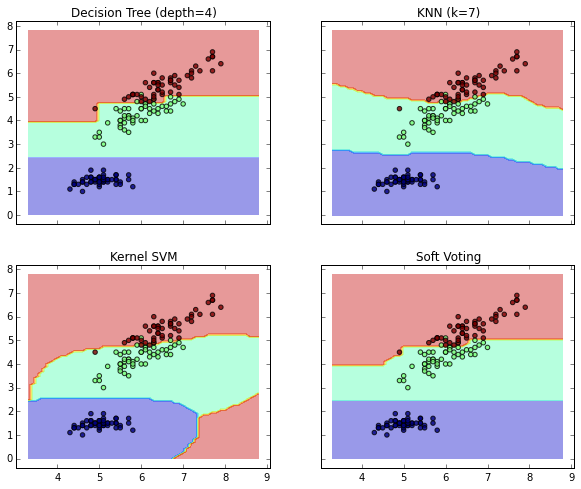

In [32]:
from itertools import product

# Plotting decision regions

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
    
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]), 
                        [clf1, clf2, clf3, eclf], 
                        ['Decision Tree (depth=4)', 'KNN (k=7)', 'Kernel SVM', 'Soft Voting']):
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y,  alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)    

plt.show()

<br>
<br>

## Appendix III - GridSearch Support

[[back to top](#Sections)]

In [71]:
from sklearn.grid_search import GridSearchCV

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = EnsembleClassifier(clfs=[clf1, clf2, clf3], voting='soft')

params = {'logisticregression__C': [1.0, 100.0],
          'randomforestclassifier__n_estimators': [20, 200],}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid.fit(iris.data, iris.target)

for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
            % (mean_score, scores.std() / 2, params))

0.953 (+/-0.013) for {'randomforestclassifier__n_estimators': 20, 'logisticregression__C': 1.0}
0.960 (+/-0.012) for {'randomforestclassifier__n_estimators': 200, 'logisticregression__C': 1.0}
0.960 (+/-0.012) for {'randomforestclassifier__n_estimators': 20, 'logisticregression__C': 100.0}
0.953 (+/-0.017) for {'randomforestclassifier__n_estimators': 200, 'logisticregression__C': 100.0}


In [74]:
[mean_score for params, mean_score, scores in grid.grid_scores_]

[0.95333333333333337,
 0.95999999999999996,
 0.95999999999999996,
 0.95333333333333337]

<br>
<br>

## Appendix IV - Verbosity Levels

[[back to top](#Sections)]

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.sklearn import EnsembleClassifier

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
y = np.array([1, 1, 1, 2, 2, 2])

### verbose=1

In [2]:
eclf1 = EnsembleClassifier(clfs=[clf1, clf2, clf3], voting='hard', verbose=1)
eclf1 = eclf1.fit(X, y)
print(eclf1.predict(X))

Fitting 3 classifiers...
Fitting clf1: logisticregression (1/3)
Fitting clf2: randomforestclassifier (2/3)
Fitting clf3: gaussiannb (3/3)
[1 1 1 2 2 2]


### verbose=2

In [3]:
eclf1 = EnsembleClassifier(clfs=[clf1, clf2, clf3], voting='hard', verbose=2)
eclf1 = eclf1.fit(X, y)
print(eclf1.predict(X))

Fitting 3 classifiers...
Fitting clf1: logisticregression (1/3)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0)
Fitting clf2: randomforestclassifier (2/3)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
Fitting clf3: gaussiannb (3/3)
GaussianNB()
[1 1 1 2 2 2]


### verbose=3

In [4]:
eclf1 = EnsembleClassifier(clfs=[clf1, clf2, clf3], voting='hard', verbose=3)
eclf1 = eclf1.fit(X, y)
print(eclf1.predict(X))

Fitting 3 classifiers...
Fitting clf1: logisticregression (1/3)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=1)
[LibLinear]Fitting clf2: randomforestclassifier (2/3)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=1, warm_start=False)
Fitting clf3: gaussiannb (3/3)
GaussianNB()
[1 1 1 2 2 2]


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


### verbose=4

In [5]:
eclf1 = EnsembleClassifier(clfs=[clf1, clf2, clf3], voting='hard', verbose=4)
eclf1 = eclf1.fit(X, y)
print(eclf1.predict(X))

Fitting 3 classifiers...
Fitting clf1: logisticregression (1/3)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=2)
[LibLinear]Fitting clf2: randomforestclassifier (2/3)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=2, warm_start=False)
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
Fitting clf3: gaussiannb (3/3)
GaussianNB()
[1 1 1 2 2 2]


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
